In [1]:
import random
import os.path

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread

import helpers
from create_alexnet import create_alexnet
import hamsterhare

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%autosave 0

Autosave disabled


## Download Hamsters and Hares

The following line downloads a small dataset, consisting of two ILSVRC synsets: hamsters and hares, and then creates training/validation splits of file names (we'll be loading in the images lazily instead of putting it all in memory).

In [2]:
hamsterhare.download_dataset()
train_data, valid_data = hamsterhare.create_dataset()

Dataset downloaded.
Extracting dataset...
data/hamsterhare already present - don't need to extract data/hamsterhare.tar.gz.
Dataset extracted
Number of training images: 2082
Number of validation images: 520


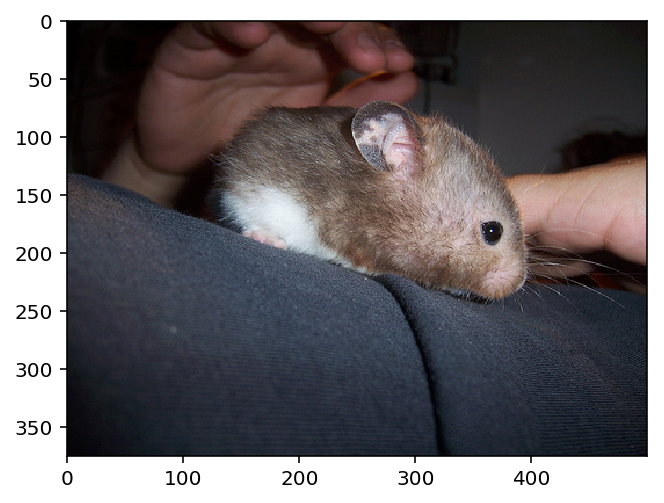

In [3]:
# Show random image from training set
filename = random.choice(train_data)
image = imread(filename)
plt.imshow(image)
plt.show()

## Load in Pre-Trained AlexNet model

Below, we download the weights for a pre-trained AlexNet model, builds the model, and exports it to disk (both for TensorBoard and future use).

In [4]:
# Creates the full alexnet model in raw tensorflow and initializes all the weights to the downloaded files
create_alexnet()

Weights downloaded.
Creating AlexNet model.
Model created.
Exporting TensorBoard graph to tbout/alexnet
Exporting TensorFlow model to data/alexnet


Now that the model is saved, we can import the graph description from disc by using `tf.train.import_meta_graph()`. We'll cover exporting and loading models in more detail in the next class.

In [21]:
graph = tf.Graph()
with graph.as_default():
    saver = tf.train.import_meta_graph('data/alexnet.meta')

Let's open up the model in TensorBoard

```
tensorboard --logdir=/notebooks/1A_Tensorflow/AAA_TF_Metis/sf17_deeplearn1/notebooks/tbout/alexnet
```

Use the graph explorer to find the string name of the input placeholder, as well as the the output of `fc7`, the second to last layer in the network. For example:

<img src='../pics/hamsterhare_op_name.png'>

The input `Operation` name is `'input'` (no slashes, which correspond to nested name scopes), and the output `Tensor` name is `'input:0'`.

We'll also need to create our own placeholder for the labels.

In [7]:
# handle to input
inputs = graph.get_tensor_by_name('input:0')

# handle to input to last layer
fc7 = graph.get_tensor_by_name('fc7/relu:0')

In [8]:
fc7

<tf.Tensor 'fc7/relu:0' shape=(?, 4096) dtype=float32>

We'll use a layer function to create our new logit output. Notice that this function now returns the weights and bias in addition to the activation/z values (so we don't have to 

In [9]:
def fully_connected_layer(inputs, depth, bval=0.01, activation_fn=tf.nn.relu, 
                          keep_prob=None, scope=None):
    inputs = tf.convert_to_tensor(inputs)
    prev_shape = inputs.get_shape().as_list()
    fan_in = prev_shape[-1]
    with tf.variable_scope(scope, 'fully_connected'):
        xavier_stddev = tf.sqrt(tf.constant(2.0, dtype=tf.float32) / fan_in, name='xavier_stddev')
        w = tf.Variable(tf.truncated_normal([fan_in, depth], stddev=xavier_stddev), name='W')
        b = tf.Variable(tf.constant(bval, shape=[depth]), name='bias')
        z = tf.matmul(inputs, w) + b
        a = z if activation_fn is None else activation_fn(z)
        a = a if keep_prob is None else tf.nn.dropout(a, keep_prob)
        # Note that we're returning the weights as well as the activation!
        # need to pass in handles to weight and bias to our tf.train.Optimizer...
        # if we didn't do this we'd need to do a graph.get_tensor_by_name()
        return a, w, b

In [10]:
with graph.as_default():
    labels = tf.placeholder(tf.int32, [None])
    one_hot_labels = tf.one_hot(labels, 2) # two indices b/c hamsters and hares
    learning_rate = tf.placeholder(tf.float32, [])
    
    global_step = tf.Variable(0, trainable=False, name='global_step')
    inc_step = global_step.assign_add(1)
    
    ### YOUR CODE HERE
    # Create final layer here - depth is 2 b/c two output classes, no activation fn because our softmax
    # will be expecting the unscaled logits (i.e. "z"s)
    logits, w, b = fully_connected_layer(fc7, depth=2, activation_fn=None)
    # now have to use a named parameter in current version of this
    # need to reduce the losses down to a single scalar thus reduce_mean
    with tf.name_scope('loss_stuff'):
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=one_hot_labels, logits=logits))
        # train = tf.train.MomentumOptimizer(learning_rate, 0.9).minimize(loss)
        # var list tells the training step which variables we'll be optiminizing
        # Adam Optimizer needs a global step since its rescaling - two branches, sum of squared updates, sum of updates
        # and then divides by factor of the Beta term to the number of training steps thus needs to know global step
        train = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step=global_step, var_list=[w,b])
        ###

        label_prediction = tf.argmax(logits, 1)
        correct_prediction = tf.equal(label_prediction, tf.argmax(one_hot_labels, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    init = tf.global_variables_initializer()

In [11]:
writer = tf.summary.FileWriter('tbout/alexnet_transfer', graph=graph)
writer.close()

In [12]:
train_gen = hamsterhare.batch_generator(train_data, 32, 5, should_distort=True)

In [13]:
sess = tf.Session(graph=graph)
sess.run(init)

In [14]:
for data_batch, label_batch, epoch in train_gen:
    data_batch = np.squeeze(data_batch)
    feed_dict = {inputs: data_batch, labels: label_batch, learning_rate: 0.02}
    err, acc, step, _ = sess.run([loss, accuracy, inc_step, train], feed_dict=feed_dict)
    if step % 25 == 0:
        print("Step: {}\t Accuracy: {}\t Error: {}".format(step, acc, err))
    if step > 200:
        break

Step: 50	 Accuracy: 0.9375	 Error: 1.5463194847106934
skipping file data/hamsterhare/hamster/.DS_Store
skipping file data/hamsterhare/hamster/._.DS_Store
Step: 100	 Accuracy: 1.0	 Error: 0.0001017729373415932
Step: 150	 Accuracy: 1.0	 Error: 0.0
skipping file data/hamsterhare/hamster/._.DS_Store
skipping file data/hamsterhare/hamster/.DS_Store
Step: 200	 Accuracy: 1.0	 Error: 0.0


In [15]:
def check_accuracy(valid_data):
    batch_size = 50
    num_correct = 0
    total = 0
    for data_batch, label_batch, epoch in hamsterhare.batch_generator(valid_data, 50, 1):
        if epoch > 0:
            break
        feed_dict = {inputs: data_batch, labels: label_batch}
        correct_guesses = sess.run(correct_prediction, feed_dict=feed_dict)
        num_correct += np.sum(correct_guesses)
        total += len(data_batch)
    acc = num_correct / float(total)
    print('\nAccuracy: {}'.format(acc))

In [16]:
check_accuracy(valid_data)


Accuracy: 0.972


Guess: hare


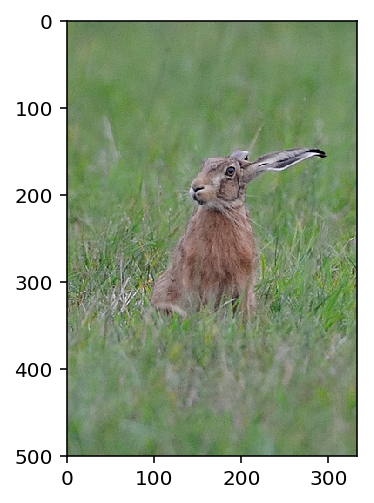

In [17]:
# Spot check!
filename = random.choice(valid_data)
image = imread(filename)
feed_dict = {inputs: [image]}
guess = sess.run(label_prediction, feed_dict=feed_dict)
if guess[0] == 1:
    print('Guess: hamster')
else:
    print('Guess: hare')
plt.imshow(image)
plt.show()

### Add a Saver so can easily load model in the future

In [18]:
with graph.as_default():
    saver = tf.train.Saver()

saver.save(sess, 'data/alexnet_transfer', global_step=100)

'data/alexnet_transfer-100'

In [19]:
saver.save(sess, 'data/alexnet_transfer', global_step=200)

'data/alexnet_transfer-200'

In [20]:
saver.save(sess, 'data/alexnet_transfer')

'data/alexnet_transfer'